Given a feature vector of image tokens, compute its attention pattern to text tokens. This is crucial tool to find circuits.

In [1]:
import sys
from os.path import join
import torch
import matplotlib.pyplot as plt

sys.path.append("/n/home13/xupan/sompolinsky_lab/DiffusionObjectRelation/PixArt-alpha")
from diffusion.utils.misc import read_config, set_random_seed, \
    init_random_seed, DebugUnderflowOverflow
sys.path.append("/n/home13/xupan/sompolinsky_lab/DiffusionObjectRelation")
from utils.pixart_sampling_utils import visualize_prompts, load_embed_and_mask
from utils.pixart_utils import construct_diffuser_pipeline_from_config, construct_pixart_transformer_from_config, state_dict_convert
from utils.attention_map_store_utils import replace_attn_processor, AttnProcessor2_0_Store, PixArtAttentionVisualizer_Store
from utils.custom_text_encoding_utils import save_prompt_embeddings_randemb, RandomEmbeddingEncoder, RandomEmbeddingEncoder_wPosEmb
# subclass a new pipeline from PixArtAlphaPipeline
import os
import torch
from torch.autograd.functional import jacobian
from torch import vmap # Import vmap
from typing import Callable, List, Optional, Tuple, Union, Dict, Any
from diffusers.pipelines.pipeline_utils import DiffusionPipeline, ImagePipelineOutput
from diffusers.pipelines.pixart_alpha.pipeline_pixart_alpha import retrieve_timesteps, PixArtAlphaPipeline
import numpy as np
# from diffusers.pipelines.pixart_alpha import EXAMPLE_DOC_STRING # Keep commented

import cv2
import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Required for np.linspace and np.empty

import matplotlib.colors as mcolors

class PixArtAlphaPipeline_custom_jacobian(PixArtAlphaPipeline):
    
    def get_encoder_hidden_states(self, prompt):
        do_classifier_free_guidance = True
        negative_prompt = ""
        num_images_per_prompt = 1
        device = "cuda"
        clean_caption = True
        max_sequence_length = 20
        (
            prompt_embeds,
            prompt_attention_mask,
            negative_prompt_embeds,
            negative_prompt_attention_mask,
        ) = self.encode_prompt(
            prompt,
            do_classifier_free_guidance,
            negative_prompt=negative_prompt,
            num_images_per_prompt=num_images_per_prompt,
            device=device,
            # prompt_embeds=prompt_embeds,
            # negative_prompt_embeds=negative_prompt_embeds,
            # prompt_attention_mask=prompt_attention_mask,
            # negative_prompt_attention_mask=negative_prompt_attention_mask,
            clean_caption=clean_caption,
            max_sequence_length=max_sequence_length,
        )
        return prompt_embeds, prompt_attention_mask
    
    def plot_attention_map(self, attention_map, word_tokens, title = None):
        num_heads = 12

        fig_width = 10 # Adjusted width for a single column
        fig_height_per_plot = 0.5 # Approximate height for each plot
        fig = plt.figure(figsize=(fig_width, fig_height_per_plot * num_heads))

        # Create a GridSpec with 12 rows for plots and 2 columns (1 for plots, 1 for colorbar)
        gs = fig.add_gridspec(num_heads, 2, width_ratios=[1, 0.05], wspace=0.3)

        # Create a list to store subplot axes, one for each head
        axes = []
        for i in range(num_heads):
            ax = fig.add_subplot(gs[i, 0]) # Each plot occupies a full row in the first column
            axes.append(ax)

        # Create a dedicated axis for the global colorbar, spanning all rows in the last column
        cbar_ax = fig.add_subplot(gs[:, 1])

        fig.suptitle(title, fontsize=16)

        # Adjust the attention_map to ensure it matches the expected shape
        # This line ensures that the attention_map has the correct number of columns
        # corresponding to the word tokens.
        attention_map = attention_map[:, :len(word_tokens)]

        mappable_for_cbar = None # Initialize a variable to store a mappable object for the global colorbar

        # Iterate over each head
        for i in range(num_heads):
            ax = axes[i] # Get the current subplot axis from the list
            head_attention = attention_map[i].reshape(1, -1) # Reshape to (1, N) for heatmap

            # Plot heatmap with specified vmin/vmax (0-1 range) and no individual colorbar
            heatmap_plot = sns.heatmap(head_attention, ax=ax, cmap='viridis', cbar=False,
                                    xticklabels=False, yticklabels=False, vmin=0, vmax=1)

            # Set aspect ratio to make cells wider than tall, giving a "background for text" feel.
            # A value less than 1 makes the cells wider relative to their height.
            ax.set_aspect(0.5) # Adjust this value (e.g., 0.3 to 0.7) for desired text background shape

            # Store the mappable object (QuadMesh) from the first heatmap for the global colorbar
            if mappable_for_cbar is None:
                mappable_for_cbar = heatmap_plot.collections[0]

            # Add text (word tokens) on top of the colors
            for j, token in enumerate(word_tokens):
                value = head_attention[0, j]
                # Choose text color based on background intensity for readability
                # A simple heuristic: if value is low (dark background), use white text; otherwise, black.
                text_color = 'white' if value < 0.5 else 'black'
                ax.text(j + 0.5, 0.5, token, ha='center', va='center', color=text_color, fontsize=10)

            # Place the subplot title on the left center, outside the subplot
            ax.text(-0.1, 0.5, f'Head {i+1}', ha='right', va='center', transform=ax.transAxes, fontsize=12)
            
            # Remove ticks and labels as text is placed directly on the heatmap
            ax.set_xticks([])
            ax.set_yticks([])

        # Create a single colorbar for the entire figure using the stored mappable object
        if mappable_for_cbar:
            cbar = fig.colorbar(mappable_for_cbar, cax=cbar_ax, orientation='vertical')
            cbar.set_label('Attention Weight', rotation=270, labelpad=15)
            cbar.set_ticks(np.linspace(0, 1, 6)) # Set ticks from 0 to 1 (e.g., [0.0, 0.2, ..., 1.0])
            cbar.ax.tick_params(labelsize=10) # Adjust colorbar tick label size

        # Adjust rect to make space for suptitle, colorbar, and the new left-aligned head labels
        # plt.tight_layout(rect=[0.05, 0.03, 1, 0.95]) # Increased left margin to accommodate head labels
        plt.tight_layout()
        plt.show()
        return fig
    
    def feature_vector_cross_attn_map(self, layer, feature, prompt, title = None):
        '''
        feature: shape [768]
        prompt: str
        output: shape [heads, prompt_tokens]
        '''
        feature = feature*np.sqrt(np.sqrt(768))
        with torch.no_grad():
            cross_attn_layer = self.transformer.transformer_blocks[layer].attn2
            
            prompt_embeds, prompt_attention_mask = self.get_encoder_hidden_states(prompt)
            encoder_hidden_states = self.transformer.caption_projection(prompt_embeds)
            encoder_attention_mask = prompt_attention_mask
            
            # if encoder_attention_mask is not None and encoder_attention_mask.ndim == 2:
            encoder_attention_mask = (1 - encoder_attention_mask.to(encoder_hidden_states.dtype)) * -10000.0
            encoder_attention_mask = encoder_attention_mask.unsqueeze(1)
            
            norm_hidden_states = torch.from_numpy(feature).to("cuda")
            norm_hidden_states = norm_hidden_states.unsqueeze(0).unsqueeze(0).to(dtype=encoder_hidden_states.dtype)
            
            attn_output = cross_attn_layer(
                            norm_hidden_states,
                            encoder_hidden_states=encoder_hidden_states,
                            attention_mask=encoder_attention_mask
                        )
        attention_map = cross_attn_layer.processor.attn_map.squeeze()
        attention_map = attention_map.detach().cpu().numpy()

        word_tokens = self.tokenizer.convert_ids_to_tokens(self.tokenizer.encode(prompt))
        word_tokens = [token.replace("▁", "") for token in word_tokens]
        # word_tokens

        attention_map = attention_map[:, 0:len(word_tokens)]
        
        fig = self.plot_attention_map(attention_map, word_tokens, title = title)

        return (attention_map, word_tokens, fig)
    
    # @replace_example_docstring(EXAMPLE_DOC_STRING)
    def __call__(
        self,
        prompt: Union[str, List[str]] = None,
        negative_prompt: str = "",
        num_inference_steps: int = 20,
        timesteps: List[int] = None,
        sigmas: List[float] = None,
        guidance_scale: float = 4.5,
        num_images_per_prompt: Optional[int] = 1,
        height: Optional[int] = None,
        width: Optional[int] = None,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.Tensor] = None,
        prompt_embeds: Optional[torch.Tensor] = None,
        prompt_attention_mask: Optional[torch.Tensor] = None,
        negative_prompt_embeds: Optional[torch.Tensor] = None,
        negative_prompt_attention_mask: Optional[torch.Tensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        callback: Optional[Callable[[int, int, torch.Tensor], None]] = None,
        callback_steps: int = 1,
        clean_caption: bool = True,
        use_resolution_binning: bool = True,
        max_sequence_length: int = 120,
        return_sample_pred_traj: bool = False,
        device: str = "cuda",
        weight_dtype: torch.dtype = torch.float16,
        jacobian: bool = False,
        **kwargs,
    ) -> Union[ImagePipelineOutput, Tuple]:
        """
        Function invoked when calling the pipeline for generation.

        Args:
            prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts to guide the image generation. If not defined, one has to pass `prompt_embeds`.
                instead.
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation. If not defined, one has to pass
                `negative_prompt_embeds` instead. Ignored when not using guidance (i.e., ignored if `guidance_scale` is
                less than `1`).
            num_inference_steps (`int`, *optional*, defaults to 100):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            timesteps (`List[int]`, *optional*):
                Custom timesteps to use for the denoising process with schedulers which support a `timesteps` argument
                in their `set_timesteps` method. If not defined, the default behavior when `num_inference_steps` is
                passed will be used. Must be in descending order.
            sigmas (`List[float]`, *optional*):
                Custom sigmas to use for the denoising process with schedulers which support a `sigmas` argument in
                their `set_timesteps` method. If not defined, the default behavior when `num_inference_steps` is passed
                will be used.
            guidance_scale (`float`, *optional*, defaults to 4.5):
                Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
                `guidance_scale` is defined as `w` of equation 2. of [Imagen
                Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
                1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
                usually at the expense of lower image quality.
            num_images_per_prompt (`int`, *optional*, defaults to 1):
                The number of images to generate per prompt.
            height (`int`, *optional*, defaults to self.unet.config.sample_size):
                The height in pixels of the generated image.
            width (`int`, *optional*, defaults to self.unet.config.sample_size):
                The width in pixels of the generated image.
            eta (`float`, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) in the DDIM paper: https://arxiv.org/abs/2010.02502. Only applies to
                [`schedulers.DDIMScheduler`], will be ignored for others.
            generator (`torch.Generator` or `List[torch.Generator]`, *optional*):
                One or a list of [torch generator(s)](https://pytorch.org/docs/stable/generated/torch.Generator.html)
                to make generation deterministic.
            latents (`torch.Tensor`, *optional*):
                Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor will ge generated by sampling using the supplied random `generator`.
            prompt_embeds (`torch.Tensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
                provided, text embeddings will be generated from `prompt` input argument.
            prompt_attention_mask (`torch.Tensor`, *optional*): Pre-generated attention mask for text embeddings.
            negative_prompt_embeds (`torch.Tensor`, *optional*):
                Pre-generated negative text embeddings. For PixArt-Alpha this negative prompt should be "". If not
                provided, negative_prompt_embeds will be generated from `negative_prompt` input argument.
            negative_prompt_attention_mask (`torch.Tensor`, *optional*):
                Pre-generated attention mask for negative text embeddings.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.stable_diffusion.IFPipelineOutput`] instead of a plain tuple.
            callback (`Callable`, *optional*):
                A function that will be called every `callback_steps` steps during inference. The function will be
                called with the following arguments: `callback(step: int, timestep: int, latents: torch.Tensor)`.
            callback_steps (`int`, *optional*, defaults to 1):
                The frequency at which the `callback` function will be called. If not specified, the callback will be
                called at every step.
            clean_caption (`bool`, *optional*, defaults to `True`):
                Whether or not to clean the caption before creating embeddings. Requires `beautifulsoup4` and `ftfy` to
                be installed. If the dependencies are not installed, the embeddings will be created from the raw
                prompt.
            use_resolution_binning (`bool` defaults to `True`):
                If set to `True`, the requested height and width are first mapped to the closest resolutions using
                `ASPECT_RATIO_1024_BIN`. After the produced latents are decoded into images, they are resized back to
                the requested resolution. Useful for generating non-square images.
            max_sequence_length (`int` defaults to 120): Maximum sequence length to use with the `prompt`.

        Examples:

        Returns:
            [`~pipelines.ImagePipelineOutput`] or `tuple`:
                If `return_dict` is `True`, [`~pipelines.ImagePipelineOutput`] is returned, otherwise a `tuple` is
                returned where the first element is a list with the generated images
        """
        if "mask_feature" in kwargs:
            deprecation_message = "The use of `mask_feature` is deprecated. It is no longer used in any computation and that doesn't affect the end results. It will be removed in a future version."
            # deprecate("mask_feature", "1.0.0", deprecation_message, standard_warn=False)
        # 1. Check inputs. Raise error if not correct
        height = height or self.transformer.config.sample_size * self.vae_scale_factor
        width = width or self.transformer.config.sample_size * self.vae_scale_factor
        # if use_resolution_binning:
        #     if self.transformer.config.sample_size == 128:
        #         aspect_ratio_bin = ASPECT_RATIO_1024_BIN
        #     elif self.transformer.config.sample_size == 64:
        #         aspect_ratio_bin = ASPECT_RATIO_512_BIN
        #     elif self.transformer.config.sample_size == 32:
        #         aspect_ratio_bin = ASPECT_RATIO_256_BIN
        #     else:
        #         raise ValueError("Invalid sample size")
        #     orig_height, orig_width = height, width
        #     height, width = self.image_processor.classify_height_width_bin(height, width, ratios=aspect_ratio_bin)

        self.check_inputs(
            prompt,
            height,
            width,
            negative_prompt,
            callback_steps,
            prompt_embeds,
            negative_prompt_embeds,
            prompt_attention_mask,
            negative_prompt_attention_mask,
        )

        # 2. Default height and width to transformer
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]
        
        # Save original batch size for Jacobian calculation later
        orig_batch_size = batch_size

        device = self._execution_device

        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0

        # 3. Encode input prompt
        print(f"prompt: {prompt}")
        print(f"do_classifier_free_guidance: {do_classifier_free_guidance}")
        print(f"negative_prompt: {negative_prompt}")
        print(f"num_images_per_prompt: {num_images_per_prompt}")
        print(f"device: {device}")
        print(f"clean_caption: {clean_caption}")
        print(f"max_sequence_length: {max_sequence_length}")

        (
            prompt_embeds,
            prompt_attention_mask,
            negative_prompt_embeds,
            negative_prompt_attention_mask,
        ) = self.encode_prompt(
            prompt,
            do_classifier_free_guidance,
            negative_prompt=negative_prompt,
            num_images_per_prompt=num_images_per_prompt,
            device=device,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            prompt_attention_mask=prompt_attention_mask,
            negative_prompt_attention_mask=negative_prompt_attention_mask,
            clean_caption=clean_caption,
            max_sequence_length=max_sequence_length,
        )
        if do_classifier_free_guidance:
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds], dim=0)
            prompt_attention_mask = torch.cat([negative_prompt_attention_mask, prompt_attention_mask], dim=0)
        # print(prompt_embeds.shape)
        # print(prompt_attention_mask.shape)
        # 4. Prepare timesteps
        timesteps, num_inference_steps = retrieve_timesteps(
            self.scheduler, num_inference_steps, device, timesteps, sigmas
        )
        
        # print(timesteps)

        # 5. Prepare latents.
        latent_channels = self.transformer.config.in_channels
        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            latent_channels,
            height,
            width,
            prompt_embeds.dtype,
            device,
            generator,
            latents,
        )

        # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        # 6.1 Prepare micro-conditions.
        added_cond_kwargs = {"resolution": None, "aspect_ratio": None}
        if self.transformer.config.sample_size == 128:
            resolution = torch.tensor([height, width]).repeat(batch_size * num_images_per_prompt, 1)
            aspect_ratio = torch.tensor([float(height / width)]).repeat(batch_size * num_images_per_prompt, 1)
            resolution = resolution.to(dtype=prompt_embeds.dtype, device=device)
            aspect_ratio = aspect_ratio.to(dtype=prompt_embeds.dtype, device=device)

            if do_classifier_free_guidance:
                resolution = torch.cat([resolution, resolution], dim=0)
                aspect_ratio = torch.cat([aspect_ratio, aspect_ratio], dim=0)

            added_cond_kwargs = {"resolution": resolution, "aspect_ratio": aspect_ratio}

        # 7. Denoising loop
        num_warmup_steps = max(len(timesteps) - num_inference_steps * self.scheduler.order, 0)

        pred_traj = []
        latents_traj = []
        t_traj = []
        jacobian_traj = []
        denoiser_traj = []
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # Expand latents for classifier free guidance
                # latents shape is (orig_batch_size, C, H, W)
                latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                # latent_model_input shape is (2*orig_batch_size, C, H, W) or (orig_batch_size, C, H, W)

                # Scale the latents (scheduler input)
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                # Prepare timestep embedding
                current_timestep = t
                if not torch.is_tensor(current_timestep):
                    is_mps = latent_model_input.device.type == "mps"
                    if isinstance(current_timestep, float):
                        dtype = torch.float32 if is_mps else torch.float64
                    else:
                        dtype = torch.int32 if is_mps else torch.int64
                    current_timestep = torch.tensor([current_timestep], dtype=dtype, device=latent_model_input.device)
                elif len(current_timestep.shape) == 0:
                    current_timestep = current_timestep[None].to(latent_model_input.device)
                # Broadcast timestep to batch dimension
                # current_timestep shape is (2*orig_batch_size,) or (orig_batch_size,)
                current_timestep = current_timestep.expand(latent_model_input.shape[0])

                # Predict the noise residual using the transformer
                # prompt_embeds shape is (2*orig_batch_size, SeqLen, Dim) or (orig_batch_size, SeqLen, Dim)
                # prompt_attention_mask shape is (2*orig_batch_size, SeqLen) or (orig_batch_size, SeqLen)
                # added_cond_kwargs has tensors of shape (2*orig_batch_size, ...) or (orig_batch_size, ...)
                print("shape of prompt_embeds: ", prompt_embeds.shape)
                noise_pred_out = self.transformer(
                    latent_model_input,
                    encoder_hidden_states=prompt_embeds,
                    encoder_attention_mask=prompt_attention_mask,
                    timestep=current_timestep,
                    added_cond_kwargs=added_cond_kwargs,
                    return_dict=False,
                )[0]
                # noise_pred_out shape is (2*orig_batch_size, C_out, H, W) or (orig_batch_size, C_out, H, W)

                # Perform classifier-free guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred_out.chunk(2)
                    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
                else:
                    noise_pred = noise_pred_out
                # noise_pred shape is (orig_batch_size, C_out, H, W)

                # Handle learned sigma prediction if necessary
                if self.transformer.config.out_channels // 2 == latent_channels:
                    # Assumes the model predicts both noise and variance, we take only the noise
                    noise_pred = noise_pred.chunk(2, dim=1)[0]
                # noise_pred final shape is (orig_batch_size, C, H, W)

                if jacobian:
                
                    latents_shape = latents.shape
                    latents_for_jacobian = latents.clone().detach().requires_grad_(True)
                    # latents_for_jacobian = latents_for_jacobian.reshape(latents_shape[0], -1)
                
                    def func_for_jacobian(x):
                        latent_model_input = torch.cat([x] * 2) if do_classifier_free_guidance else x
                        # latent_model_input shape is (2*orig_batch_size, C, H, W) or (orig_batch_size, C, H, W)

                        # Scale the latents (scheduler input)
                        latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                        # Prepare timestep embedding
                        current_timestep = t
                        if not torch.is_tensor(current_timestep):
                            is_mps = latent_model_input.device.type == "mps"
                            if isinstance(current_timestep, float):
                                dtype = torch.float32 if is_mps else torch.float64
                            else:
                                dtype = torch.int32 if is_mps else torch.int64
                            current_timestep = torch.tensor([current_timestep], dtype=dtype, device=latent_model_input.device)
                        elif len(current_timestep.shape) == 0:
                            current_timestep = current_timestep[None].to(latent_model_input.device)
                        # Broadcast timestep to batch dimension
                        # current_timestep shape is (2*orig_batch_size,) or (orig_batch_size,)
                        current_timestep = current_timestep.expand(latent_model_input.shape[0])

                        # Predict the noise residual using the transformer
                        # prompt_embeds shape is (2*orig_batch_size, SeqLen, Dim) or (orig_batch_size, SeqLen, Dim)
                        # prompt_attention_mask shape is (2*orig_batch_size, SeqLen) or (orig_batch_size, SeqLen)
                        # added_cond_kwargs has tensors of shape (2*orig_batch_size, ...) or (orig_batch_size, ...)
                        noise_pred_out = self.transformer(
                            latent_model_input,
                            encoder_hidden_states=prompt_embeds,
                            encoder_attention_mask=prompt_attention_mask,
                            timestep=current_timestep,
                            added_cond_kwargs=added_cond_kwargs,
                            return_dict=False,
                        )[0]
                        # noise_pred_out shape is (2*orig_batch_size, C_out, H, W) or (orig_batch_size, C_out, H, W)

                        # Perform classifier-free guidance
                        if do_classifier_free_guidance:
                            noise_pred_uncond, noise_pred_text = noise_pred_out.chunk(2)
                            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
                            noise_pred = noise_pred.chunk(2, dim=1)[0]
                        else:
                            noise_pred = noise_pred_out
                        # Flatten the noise prediction
                        # return noise_pred.flatten()
                        return noise_pred
                    
                    # Compute the Jacobian of the noise prediction with respect to the latents
                    jacobian = torch.autograd.functional.jacobian(func_for_jacobian, latents_for_jacobian)
                    jacobian_traj.append(jacobian.detach().cpu())
                    # jacobian = jacobian.reshape(latents_shape[0], -1, latents_shape[1], latents_shape[2], latents_shape[3])

                # Store trajectories (use original latents, not the one requiring grad)
                latents_traj.append(latents)
                pred_traj.append(noise_pred.cpu()) # Store the final noise prediction used for the step

                # Compute the previous noisy sample x_t -> x_t-1 using the scheduler
                # Use the original `latents` tensor, which does not require grad here.
                
                # save denoiser
                # print(self.scheduler.step_index)
                if self.scheduler.step_index is None:
                    self.scheduler._init_step_index(t)
                denoiser_traj.append(self.scheduler.convert_model_output(model_output=noise_pred, sample=latents))
                
                if num_inference_steps == 1:
                    # Special case for single-step sampling (e.g., DMD)
                    latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).pred_original_sample
                else:
                    # Standard scheduler step
                    latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]
                
                # Store timestep
                t_traj.append(t)

                # Call the callback, if provided, and update progress bar
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        step_idx = i // getattr(self.scheduler, "order", 1)
                        callback(step_idx, t, latents)

        latents_traj.append(latents)
        
        images = []
        if not output_type == "latent":
            images.append(latents_traj[-1])
            # for i in range(len(latents_traj)):
            #     image = self.vae.decode(latents_traj[i] / self.vae.config.scaling_factor, return_dict=False)[0]
            #     image = self.image_processor.postprocess(image.detach(), output_type=output_type)
                # images.append(image)
                # if use_resolution_binning:
            #     image = self.image_processor.resize_and_crop_tensor(image, orig_width, orig_height)
        else:
            for i in range(len(latents_traj)):
                image = self.vae.decode(latents_traj[i].to(weight_dtype) / self.vae.config.scaling_factor, return_dict=False)[0]
                image = self.image_processor.postprocess(image.detach(), output_type="pil")
                images.append(image)
            # images = [ImagePipelineOutput(images=image) for image in images]

        # if not output_type == "latent":
        #     image = self.image_processor.postprocess(image.detach(), output_type=output_type)
        
        denoiser_image_traj = []
        for i in range(len(denoiser_traj)):
            image = self.vae.decode(denoiser_traj[i].to(weight_dtype) / self.vae.config.scaling_factor, return_dict=False)[0]
            image = self.image_processor.postprocess(image.detach(), output_type="pil")
            denoiser_image_traj.append(image)

        # Offload all models
        self.maybe_free_model_hooks()
        latents_traj = torch.stack(latents_traj)
        pred_traj = torch.stack(pred_traj)
        output_dict = {}
        output_dict['images'] = images
        output_dict['pred_traj'] = pred_traj
        output_dict['latents_traj'] = [latent.cpu() for latent in latents_traj]
        output_dict['t_traj'] = t_traj
        output_dict['denoiser_traj'] = denoiser_image_traj
        if jacobian:
            jacobian_traj = torch.stack(jacobian_traj)
            output_dict['jacobian_traj'] = jacobian_traj
        # t_traj = torch.stack(t_traj) # Stacking list of tensors might be inefficient if they are scalars
        if not return_dict:
            return (images,)
        if return_sample_pred_traj:
            # Convert t_traj list of tensors to a single tensor if needed, or return as list
            return output_dict
        return images
    
    
    
# def visualize_prompts_with_traj_jacobian(pipeline, validation_prompts, prompt_cache_dir, max_length=120, weight_dtype=torch.float16,
#                    num_inference_steps=14, guidance_scale=4.5, num_images_per_prompt=1, device="cuda", random_seed=0, return_sample_pred_traj=True, jacobian=False): # Default num_images_per_prompt=1 for Jacobian
#     # logger.info("Running validation... ")
#     # device = accelerator.device
#     # model = accelerator.unwrap_model(model)
#     if validation_prompts is None:
#         validation_prompts = [
#             "triangle is to the upper left of square", 
#             "blue triangle is to the upper left of red square", 
#             "triangle is above and to the right of square", 
#             "blue circle is above and to the right of blue square", 
#             "triangle is to the left of square", 
#             "triangle is to the left of triangle", 
#             "circle is below red square",
#             "red circle is to the left of blue square",
#             "blue square is to the right of red circle",
#             "red circle is above square",
#             "triangle is above red circle",
#             "red is above blue",
#             "red is to the left of red",
#             "blue triangle is above red triangle", 
#             "blue circle is above blue square", 
#         ]
#     pipeline = pipeline.to(device)
#     pipeline.set_progress_bar_config(disable=True)
#     if random_seed is None:
#         generator = None
#     else:
#         generator = torch.Generator(device=device).manual_seed(random_seed)
#     image_logs = []
#     images = []
#     latents = []
#     pred_traj_list = []
#     latents_traj_list = []
#     t_traj_list = []
#     jacobian_traj_list = []
#     denoiser_traj_list = []
#     images_list = []
#     uncond_data = torch.load(f'{prompt_cache_dir}/uncond_{max_length}token.pth', map_location='cpu')
#     uncond_prompt_embeds = uncond_data['caption_embeds'].to(device)
#     uncond_prompt_attention_mask = uncond_data['emb_mask'].to(device)
#     visualized_prompts = []
#     for _, prompt in enumerate(validation_prompts):
#         if not os.path.exists(f'{prompt_cache_dir}/{prompt}_{max_length}token.pth'):
#             continue
#         embed = torch.load(f'{prompt_cache_dir}/{prompt}_{max_length}token.pth', map_location='cpu')
#         caption_embs, emb_masks = embed['caption_embeds'].to(device), embed['emb_mask'].to(device)
        
#         # Ensure num_images_per_prompt=1 if calculating Jacobian for simplicity
#         # The Jacobian code assumes orig_batch_size corresponds to prompt batch size
#         current_num_images_per_prompt = 1 if return_sample_pred_traj else num_images_per_prompt 

#         output = pipeline(
#             num_inference_steps=num_inference_steps,
#             num_images_per_prompt=current_num_images_per_prompt, 
#             generator=generator,
#             guidance_scale=guidance_scale,
#             prompt_embeds=caption_embs,
#             prompt_attention_mask=emb_masks,
#             negative_prompt=None,
#             negative_prompt_embeds=uncond_prompt_embeds,
#             negative_prompt_attention_mask=uncond_prompt_attention_mask,
#             use_resolution_binning=False, # need this for smaller images like ours. 
#             return_sample_pred_traj=True, # Always true to get trajectories
#             output_type="latent",
#             weight_dtype=weight_dtype,
#             jacobian=jacobian,
#         )
#         images_list.append(output['images'])
#         pred_traj_list.append(output['pred_traj'])
#         latents_traj_list.append(output['latents_traj'])
#         t_traj_list.append(output['t_traj'])
#         if jacobian:
#             jacobian_traj_list.append(output['jacobian_traj'])
#         denoiser_traj_list.append(output['denoiser_traj'])
#         visualized_prompts.append(prompt)

#     return images_list, latents_traj_list, pred_traj_list, t_traj_list, jacobian_traj_list, denoiser_traj_list


def visualize_prompts_with_traj_jacobian_no_cache(pipeline, validation_prompts = None, max_length=120, weight_dtype=torch.float16,
                   num_inference_steps=14, guidance_scale=4.5, num_images_per_prompt=1, device="cuda", random_seed=0, return_sample_pred_traj=True, jacobian=False): # Default num_images_per_prompt=1 for Jacobian

    pipeline = pipeline.to(device)
    pipeline.set_progress_bar_config(disable=True)
    if random_seed is None:
        generator = None
    else:
        generator = torch.Generator(device=device).manual_seed(random_seed)
    image_logs = []
    images = []
    latents = []
    pred_traj_list = []
    latents_traj_list = []
    t_traj_list = []
    jacobian_traj_list = []
    denoiser_traj_list = []
    images_list = []
    # uncond_data = torch.load(f'{prompt_cache_dir}/uncond_{max_length}token.pth', map_location='cpu')
    # uncond_prompt_embeds = uncond_data['caption_embeds'].to(device)
    # uncond_prompt_attention_mask = uncond_data['emb_mask'].to(device)
    visualized_prompts = []
    for _, prompt in enumerate(validation_prompts):
        # if not os.path.exists(f'{prompt_cache_dir}/{prompt}_{max_length}token.pth'):
        #     continue
        # embed = torch.load(f'{prompt_cache_dir}/{prompt}_{max_length}token.pth', map_location='cpu')
        # caption_embs, emb_masks = embed['caption_embeds'].to(device), embed['emb_mask'].to(device)
        
        # Ensure num_images_per_prompt=1 if calculating Jacobian for simplicity
        # The Jacobian code assumes orig_batch_size corresponds to prompt batch size
        current_num_images_per_prompt = 1 if return_sample_pred_traj else num_images_per_prompt 

        output = pipeline(
            prompt=prompt,
            negative_prompt="",
            num_inference_steps=num_inference_steps,
            num_images_per_prompt=current_num_images_per_prompt, 
            generator=generator,
            guidance_scale=guidance_scale,
            max_sequence_length=max_length,
            # prompt_embeds=caption_embs,
            # prompt_attention_mask=emb_masks,
            # negative_prompt=None,
            # negative_prompt_embeds=uncond_prompt_embeds,
            # negative_prompt_attention_mask=uncond_prompt_attention_mask,
            use_resolution_binning=False, # need this for smaller images like ours. 
            return_sample_pred_traj=True, # Always true to get trajectories
            output_type="latent",
            weight_dtype=weight_dtype,
            jacobian=jacobian,
        )
        images_list.append(output['images'])
        pred_traj_list.append(output['pred_traj'])
        latents_traj_list.append(output['latents_traj'])
        t_traj_list.append(output['t_traj'])
        if jacobian:
            jacobian_traj_list.append(output['jacobian_traj'])
        denoiser_traj_list.append(output['denoiser_traj'])
        visualized_prompts.append(prompt)

    return images_list, latents_traj_list, pred_traj_list, t_traj_list, jacobian_traj_list, denoiser_traj_list


/n/holylabs/LABS/sompolinsky_lab/Users/xupan/envs/pixart/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/n/holylabs/LABS/sompolinsky_lab/Users/xupan/envs/pixart/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/n/holylabs/LABS/sompolinsky_lab/Users/xupan/envs/pixart/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mm

In [2]:
savedir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot"
ckptdir = join(savedir, "checkpoints")
config = read_config(join(savedir, 'config.py'))
weight_dtype = torch.float32
if config.mixed_precision == "fp16": # accelerator.
    weight_dtype = torch.float16
elif config.mixed_precision == "bf16": # accelerator.
    weight_dtype = torch.bfloat16
    
pipeline = construct_diffuser_pipeline_from_config(config, pipeline_class=PixArtAlphaPipeline_custom_jacobian)
ckpt = torch.load(join(ckptdir, "epoch_4000_step_160000.pth"))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict_ema']))
pipeline = pipeline.to("cuda")
pipeline.set_progress_bar_config(disable=True)

validation_prompts = config.validation_prompts
print("validation_prompts: ", validation_prompts)

prompt_cache_dir = config.prompt_cache_dir

from transformers import T5Tokenizer, T5EncoderModel

text_feat_dir = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRel_pilot_rndembposemb/caption_feature_wmask'
T5_path = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models/t5_ckpts/t5-v1_1-xxl"

tokenizer = T5Tokenizer.from_pretrained(T5_path)
rnd_encoding = torch.load(join(text_feat_dir, "word_embedding_dict.pt"))
rndpos_encoder = RandomEmbeddingEncoder_wPosEmb(rnd_encoding["embedding_dict"], 
                                              rnd_encoding["input_ids2dict_ids"], 
                                              rnd_encoding["dict_ids2input_ids"], 
                                              max_seq_len=20, embed_dim=4096,
                                              wpe_scale=1/6).to("cuda")
pipeline.text_encoder = rndpos_encoder
pipeline.text_encoder.dtype = torch.float
pipeline.tokenizer = tokenizer

pipeline.transformer = replace_attn_processor(pipeline.transformer)

image_logs, latents_traj_list, pred_traj_list, t_traj_list, jacobian_traj, denoiser_traj= visualize_prompts_with_traj_jacobian_no_cache(\
                                                                                        pipeline, 
                                                                                        validation_prompts = validation_prompts[7:8],
                                                                                        max_length=config.model_max_length, 
                                                                                        weight_dtype=weight_dtype)

# image_logs, latents_traj_list, pred_traj_list, t_traj_list, jacobian_traj, denoiser_traj= visualize_prompts_with_traj_jacobian(\
#                                                                                         pipeline, 
#                                                                                         validation_prompts[7:8], 
#                                                                                         prompt_cache_dir, 
#                                                                                         max_length=config.model_max_length, 
#                                                                                         weight_dtype=weight_dtype)


Loading pipeline components...: 100%|██████████| 3/3 [00:00<00:00,  3.83it/s]
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


validation_prompts:  ['triangle is to the upper left of square', 'blue triangle is to the upper left of red square', 'triangle is above and to the right of square', 'blue circle is above and to the right of blue square', 'triangle is to the left of square', 'triangle is to the left of triangle', 'circle is below red square', 'red circle is to the left of blue square', 'blue square is to the right of red circle', 'red circle is above square', 'triangle is above red circle', 'red is above blue', 'red is to the left of red', 'blue triangle is above red triangle', 'blue circle is above blue square']


/n/holylabs/LABS/sompolinsky_lab/Users/xupan/envs/pixart/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


prompt: red circle is to the left of blue square
do_classifier_free_guidance: True
negative_prompt: 
num_images_per_prompt: 1
device: cuda:0
clean_caption: True
max_sequence_length: 20
shape of prompt_embeds:  torch.Size([2, 20, 4096])
shape of prompt_embeds:  torch.Size([2, 20, 4096])
shape of prompt_embeds:  torch.Size([2, 20, 4096])
shape of prompt_embeds:  torch.Size([2, 20, 4096])
shape of prompt_embeds:  torch.Size([2, 20, 4096])
shape of prompt_embeds:  torch.Size([2, 20, 4096])
shape of prompt_embeds:  torch.Size([2, 20, 4096])
shape of prompt_embeds:  torch.Size([2, 20, 4096])
shape of prompt_embeds:  torch.Size([2, 20, 4096])
shape of prompt_embeds:  torch.Size([2, 20, 4096])
shape of prompt_embeds:  torch.Size([2, 20, 4096])
shape of prompt_embeds:  torch.Size([2, 20, 4096])
shape of prompt_embeds:  torch.Size([2, 20, 4096])
shape of prompt_embeds:  torch.Size([2, 20, 4096])


In [3]:
config.model_max_length

20

In [4]:
pipeline.text_encoder

RandomEmbeddingEncoder_wPosEmb()

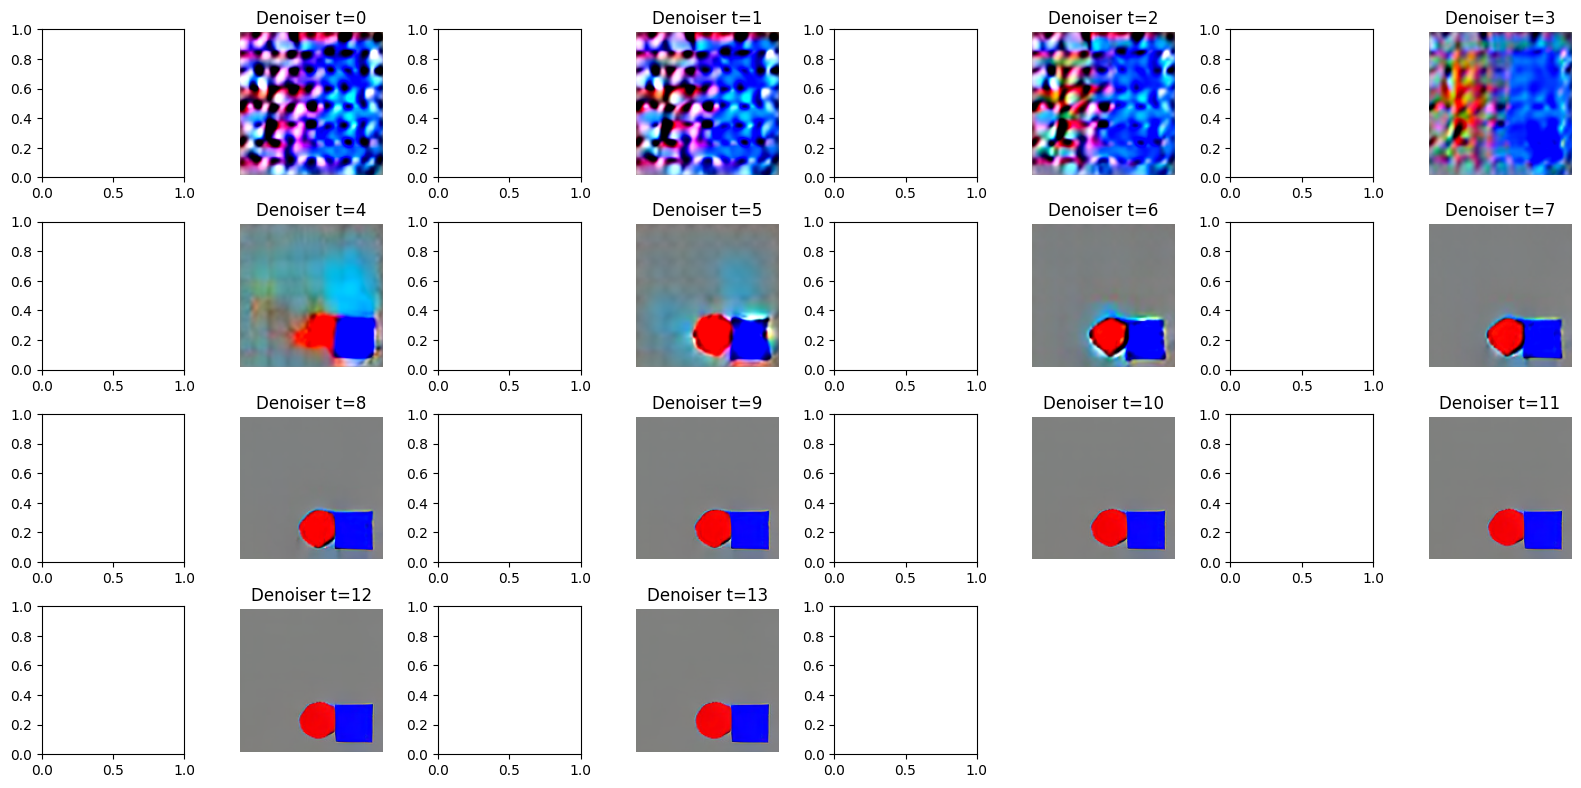

In [5]:
# jacobian_np = latents_traj_list[0].numpy()
images = denoiser_traj[0]

# cv2_objects = find_classify_objects(image_logs[0][-1][-1])
# object_location = list(cv2_objects['Center (x, y)'])

n_plots = 15#jacobian_np.shape[0]

# Make the plot grid as square as possible, with 2 columns per plot (jacobian, image)
n_pairs = n_plots
ncols = int(np.ceil(np.sqrt(n_pairs))) * 2  # 2 columns per plot (jacobian, image)
nrows = int(np.ceil(n_pairs / (ncols // 2)))

patch_size = 8

# object_location += [(64,64), (64,20), (20,20)]

# for (x,y) in object_location:
x = 9
y = 12
x = round(x/patch_size-0.5)
y = round(y/patch_size-0.5)

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))

# Ensure axes is always 2D
if nrows == 1:
    axes = np.expand_dims(axes, 0)
if ncols == 2:
    axes = np.expand_dims(axes, 1)

for idx in range(n_plots):
    pair_idx = idx
    row = pair_idx // (ncols // 2)
    col_jac = (pair_idx % (ncols // 2)) * 2
    col_img = col_jac + 1

    # Plot jacobian
    # mean_jacobian = np.mean(jacobian_np[idx,0,:,y,x,0,:,:,:], axis=(0,1))
    # norm = mcolors.SymLogNorm(linthresh=0.001, linscale=1.0, vmin=-0.01, vmax=0.01, base=10)
    # im = axes[row, col_jac].imshow(mean_jacobian, norm=norm, cmap='coolwarm')
    # axes[row, col_jac].set_title(f"Jacobian t={idx}")
    # axes[row, col_jac].axis('off')

    # Plot corresponding image (if available)
    if idx < len(images):
        axes[row, col_img].imshow(images[idx][0])
        axes[row, col_img].set_title(f"Denoiser t={idx}")
        axes[row, col_img].axis('off')
    else:
        axes[row, col_img].axis('off')

# Hide any unused subplots
for i in range(nrows):
    for j in range(ncols):
        pair_idx = i * (ncols // 2) + (j // 2)
        if (j % 2 == 0 and pair_idx >= n_plots) or (j % 2 == 1 and pair_idx >= n_plots):
            axes[i, j].axis('off')
            
fig.tight_layout()

In [6]:
pipeline.transformer

Transformer2DModel(
  (pos_embed): PatchEmbed(
    (proj): Conv2d(4, 768, kernel_size=(2, 2), stride=(2, 2))
  )
  (transformer_blocks): ModuleList(
    (0-11): 12 x BasicTransformerBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=False)
      (attn1): Attention(
        (to_q): Linear(in_features=768, out_features=768, bias=True)
        (to_k): Linear(in_features=768, out_features=768, bias=True)
        (to_v): Linear(in_features=768, out_features=768, bias=True)
        (to_out): ModuleList(
          (0): Linear(in_features=768, out_features=768, bias=True)
          (1): Dropout(p=0.0, inplace=False)
        )
      )
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=False)
      (attn2): Attention(
        (to_q): Linear(in_features=768, out_features=768, bias=True)
        (to_k): Linear(in_features=768, out_features=768, bias=True)
        (to_v): Linear(in_features=768, out_features=768, bias=True)
        (to_out): ModuleList(
          (0):

In [7]:
prompt = validation_prompts[7:8][0]
prompt_embeds, prompt_attention_mask = pipeline.get_encoder_hidden_states(prompt = prompt)
print(prompt)
print(prompt_embeds.shape)
print(prompt_attention_mask.shape)
print(prompt_embeds)
print(prompt_attention_mask)

red circle is to the left of blue square
torch.Size([1, 20, 4096])
torch.Size([1, 20])
tensor([[[ 0.1041,  0.4146, -0.2654,  ...,  0.0858, -0.0207,  0.1217],
         [ 0.2913,  0.0860,  0.1098,  ...,  0.1921,  0.1374,  0.2417],
         [ 0.3710, -0.1171,  0.1197,  ...,  0.3582,  0.2012,  0.2286],
         ...,
         [ 0.0656,  0.1284, -0.0507,  ...,  0.1502,  0.1106,  0.1653],
         [ 0.1006,  0.2843, -0.0281,  ...,  0.1502,  0.1106,  0.1653],
         [ 0.2508,  0.3391,  0.1164,  ...,  0.1502,  0.1107,  0.1653]]],
       device='cuda:0')
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       device='cuda:0')


In [8]:
prompt_attention_mask

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       device='cuda:0')

In [9]:
pipeline.transformer.config.cross_attention_dim

768

In [10]:
prompt_embeds.shape, prompt_attention_mask.shape

(torch.Size([1, 20, 4096]), torch.Size([1, 20]))

In [11]:
# https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/transformers/pixart_transformer_2d.py#L32
# https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/attention.py#L261
# https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/attention_processor.py#L50

layer = 1
cross_attn_layer = pipeline.transformer.transformer_blocks[layer].attn2

In [34]:
pipeline.get_encoder_hidden_states("")

(tensor([[[-0.0609,  0.3837,  0.2152,  ...,  0.2301,  0.0813,  0.3842],
          [ 0.3661,  0.2643,  0.2454,  ...,  0.1502,  0.1104,  0.1653],
          [ 0.3774,  0.1049,  0.2577,  ...,  0.1502,  0.1104,  0.1653],
          ...,
          [ 0.0656,  0.1284, -0.0507,  ...,  0.1502,  0.1106,  0.1653],
          [ 0.1006,  0.2843, -0.0281,  ...,  0.1502,  0.1106,  0.1653],
          [ 0.2508,  0.3391,  0.1164,  ...,  0.1502,  0.1107,  0.1653]]],
        device='cuda:0'),
 tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
        device='cuda:0'))

In [12]:
pipeline.transformer.caption_projection

PixArtAlphaTextProjection(
  (linear_1): Linear(in_features=4096, out_features=768, bias=True)
  (act_1): GELU(approximate='tanh')
  (linear_2): Linear(in_features=768, out_features=768, bias=True)
)

In [13]:
 validation_prompts[7:8][0]

'red circle is to the left of blue square'

/tmp/ipykernel_2359256/2652938256.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


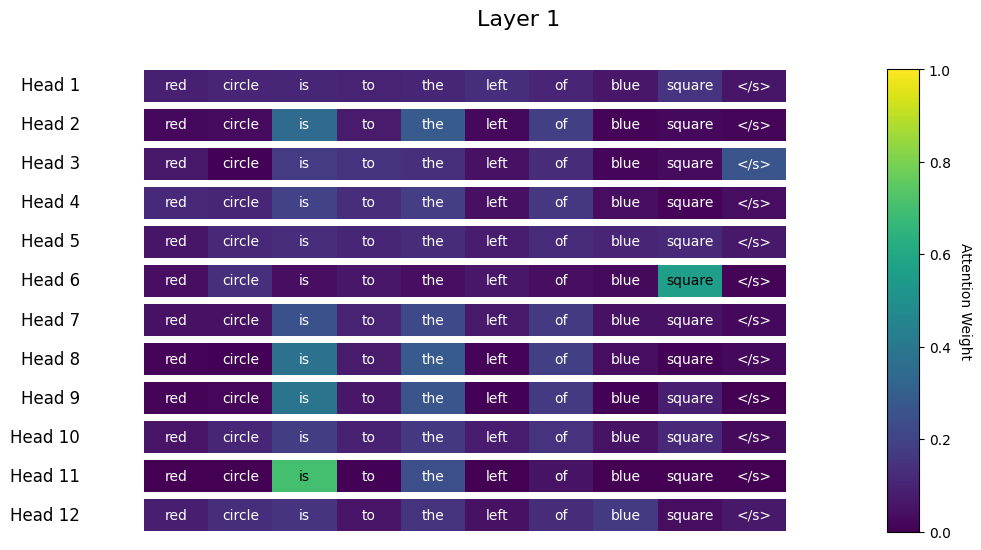

(array([[8.97840932e-02, 1.01592213e-01, 1.08186394e-01, 9.66659784e-02,
         1.05944924e-01, 1.29614815e-01, 1.04200184e-01, 6.03412166e-02,
         1.48962736e-01, 5.47074378e-02],
        [2.21286975e-02, 2.88214590e-02, 3.43302637e-01, 7.31249154e-02,
         2.81550169e-01, 2.03123223e-02, 1.87231183e-01, 9.81185492e-03,
         2.04553176e-02, 1.32614821e-02],
        [6.43344223e-02, 6.64554536e-03, 1.72685191e-01, 1.46278948e-01,
         1.33421108e-01, 4.66167852e-02, 1.23350479e-01, 1.50318546e-02,
         2.80575007e-02, 2.63578236e-01],
        [1.12847172e-01, 1.07503332e-01, 1.98828503e-01, 1.25670135e-01,
         1.82643399e-01, 4.08137254e-02, 1.57470703e-01, 3.32882814e-02,
         9.09423549e-03, 3.18405181e-02],
        [5.56402802e-02, 1.10421725e-01, 1.28771484e-01, 1.05633810e-01,
         1.24550343e-01, 7.70660490e-02, 1.17729858e-01, 1.01982169e-01,
         1.13629602e-01, 6.45746812e-02],
        [3.62589955e-02, 1.40335485e-01, 3.70335020e-02, 5.8

In [14]:
layer = 1
feature = np.random.randn(768)
prompt = validation_prompts[7:8][0]

pipeline.feature_vector_cross_attn_map(layer, feature, prompt, title = f"Layer {layer}")

In [15]:
import pickle

file_path = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot/feature_classifier/synopsis/red_blue_left_right_relation_feature_classifier_alllayers_stats_synopsis.pkl"

with open(file_path, 'rb') as f:
    feature_data = pickle.load(f)


/tmp/ipykernel_2359256/2652938256.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


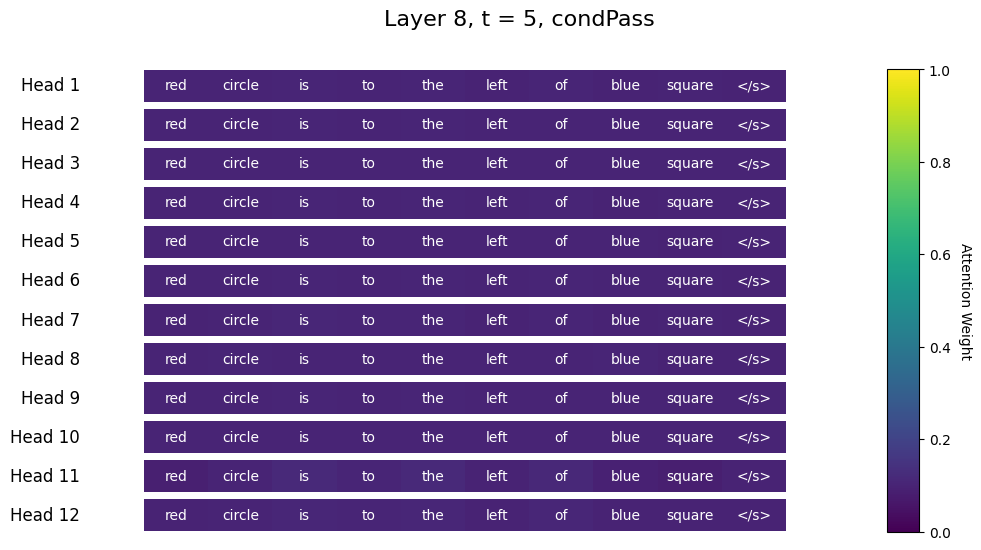

In [16]:
prompt = 'red circle is to the left of blue square'

training_passes = ["condPass", "uncondPass", "cond-uncondPass"]

for layer in range(12):
    for t in range(14):
        for training_pass in training_passes:
            layer = 8
            t = 5
            selected_row_data = feature_data[
                (feature_data['layer_index'] == layer) &
                (feature_data['t_index'] == t) &
                (feature_data['training_pass'] == training_pass)
            ]

            if not selected_row_data.empty:
                boundary_vector = selected_row_data['boundary_vector'].iloc[0]
                boundary_vector = np.array(boundary_vector)
                (attention_map, word_tokens, fig) = pipeline.feature_vector_cross_attn_map(layer, boundary_vector, prompt, title = f"Layer {layer}, t = {t}, {training_pass}")
                fig.savefig(f"/n/home13/xupan/sompolinsky_lab/object_relation/feature_attn_map/attention_map_layer_{layer}_t_{t}_{training_pass}.png", bbox_inches='tight')
                del fig
            break
        break
    break


In [17]:
np.sqrt(np.sqrt(768))

np.float64(5.2642960518099695)

In [18]:
list(pipeline.transformer.transformer_blocks[1].norm1.parameters())

[]

In [19]:
cross_attn_layer = pipeline.transformer.transformer_blocks[1].attn2
            
prompt_embeds, prompt_attention_mask = pipeline.get_encoder_hidden_states(prompt)

prompt_attention_mask

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       device='cuda:0')

In [20]:
attention_map

array([[0.0982202 , 0.09814757, 0.10517676, 0.10117542, 0.10452826,
        0.097282  , 0.10337471, 0.09762939, 0.09854302, 0.09592275],
       [0.09792216, 0.09907626, 0.10207041, 0.1003829 , 0.10179338,
        0.10033119, 0.10141604, 0.0989176 , 0.09939374, 0.09869634],
       [0.10034119, 0.10069871, 0.0997702 , 0.09945917, 0.09981902,
        0.10094777, 0.09987193, 0.09908183, 0.09995153, 0.10005873],
       [0.09767085, 0.09934818, 0.10355868, 0.10109691, 0.10315238,
        0.09874263, 0.10255279, 0.09700564, 0.09836949, 0.09850252],
       [0.09961945, 0.09912409, 0.10139539, 0.10022511, 0.10126318,
        0.09933126, 0.10094079, 0.1004147 , 0.09759197, 0.10009412],
       [0.09831812, 0.09944291, 0.10368184, 0.10075191, 0.10320958,
        0.097893  , 0.1023852 , 0.09787131, 0.09895278, 0.09749337],
       [0.09750148, 0.09826266, 0.10554466, 0.10185786, 0.10495873,
        0.09737484, 0.10387061, 0.09628165, 0.09783801, 0.09650948],
       [0.09846891, 0.10406659, 0.1009380

In [21]:
# Filter the DataFrame based on the current values of layer, t, and training_pass
# Assuming 'layer_index' is a column in feature_data
selected_row_data = feature_data[
    (feature_data['layer_index'] == layer) &
    (feature_data['t_index'] == t) &
    (feature_data['training_pass'] == training_pass)
]

# Get the boundary_vector from the selected data
# Assuming there is at most one matching row, or we want the first one if multiple exist
if not selected_row_data.empty:
    boundary_vector = selected_row_data['boundary_vector'].iloc[0]
else:
    # Handle the case where no matching data is found
    # For example, set boundary_vector to None or raise an error
    boundary_vector = None
    print(f"Warning: No boundary_vector found for layer={layer}, t={t}, training_pass='{training_pass}'")


In [22]:
feature_data.head()

,classifier,train_score,test_score,confusion_matrix,precision,recall,f1_score,layer_index,t_index,training_pass,annot_label,boundary_vector
0,"LogisticRegression(fit_intercept=False, n_jobs...",0.820536,0.823881,"[[2121, 494], [450, 2295]]",0.822876,0.836066,0.829418,0,13,condPass,leftobj_vs_rightobj,"[0.33343886468480505, 0.14950097311570262, 0.0..."
1,"LogisticRegression(fit_intercept=False, n_jobs...",0.820536,0.823881,"[[2121, 494], [450, 2295]]",0.822876,0.836066,0.829418,0,13,uncondPass,leftobj_vs_rightobj,"[0.33343886468480505, 0.14950097311570262, 0.0..."
2,"LogisticRegression(fit_intercept=False, n_jobs...",0.821823,0.817987,"[[4371, 1014], [937, 4397]]",0.812604,0.824334,0.818427,0,13,cond-uncondPass,leftobj_vs_rightobj,"[0.2849374189382954, 0.12907440249732252, 0.02..."
3,"LogisticRegression(fit_intercept=False, n_jobs...",0.819836,0.820896,"[[2111, 504], [456, 2289]]",0.819549,0.833880,0.826652,0,12,condPass,leftobj_vs_rightobj,"[0.3441371022350479, 0.15928341245376898, 0.03..."
4,"LogisticRegression(fit_intercept=False, n_jobs...",0.819836,0.820896,"[[2111, 504], [456, 2289]]",0.819549,0.833880,0.826652,0,12,uncondPass,leftobj_vs_rightobj,"[0.3441371022350479, 0.15928341245376898, 0.03..."


In [23]:
import pickle

file_path = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot/latent_store_norm1/red_blue_8_pos_rndembposemb_img_latent_residual_allblocks_prompt9_seed0.pkl"

with open(file_path, 'rb') as f:
    latent_store = pickle.load(f)



In [24]:
latent_store['block_8_residual_spatial_state_traj'].shape
latent = latent_store['block_8_residual_spatial_state_traj'][5,1,4,4,:]
latent = latent.detach().cpu().numpy()

In [25]:
np.linalg.norm(latent)

np.float32(27.71278)

/tmp/ipykernel_2359256/2652938256.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


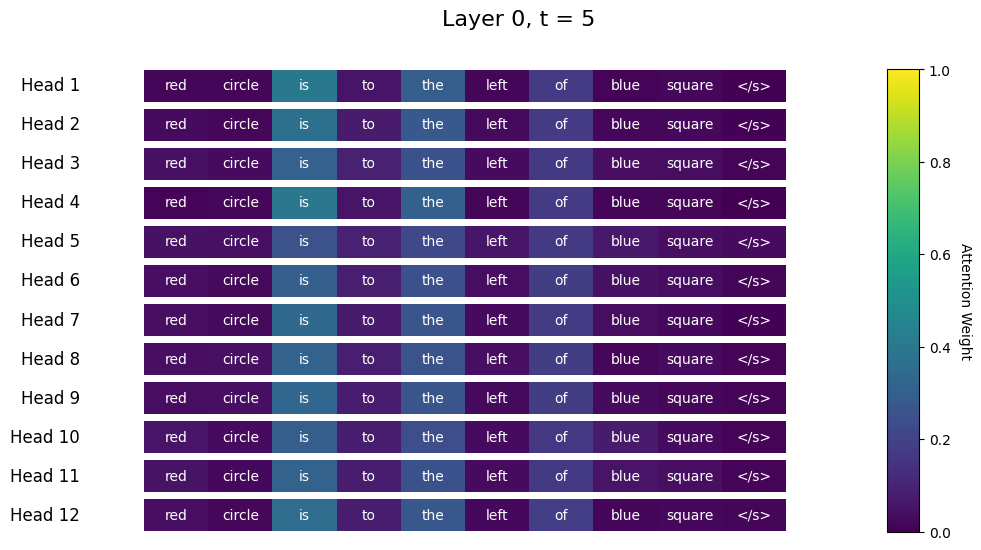

/tmp/ipykernel_2359256/2652938256.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


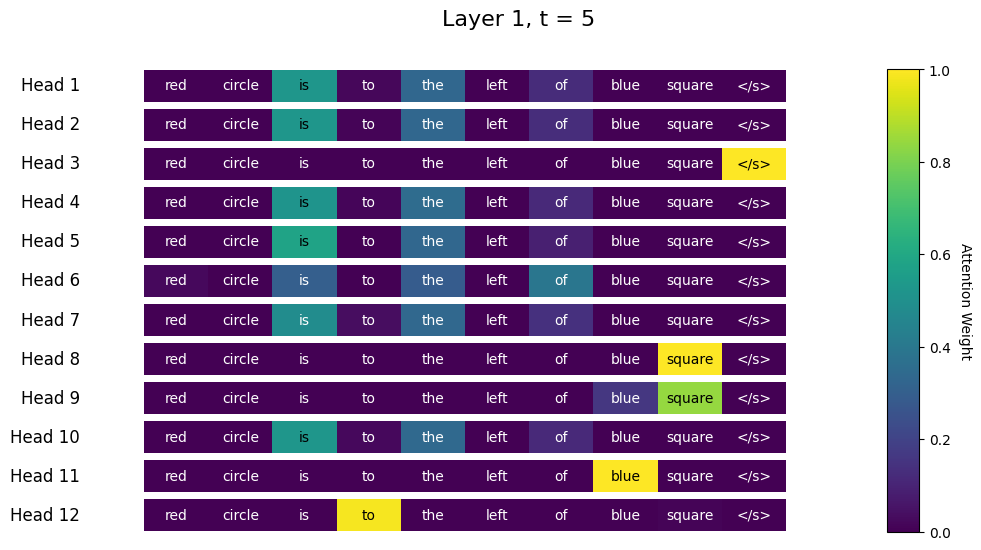

/tmp/ipykernel_2359256/2652938256.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


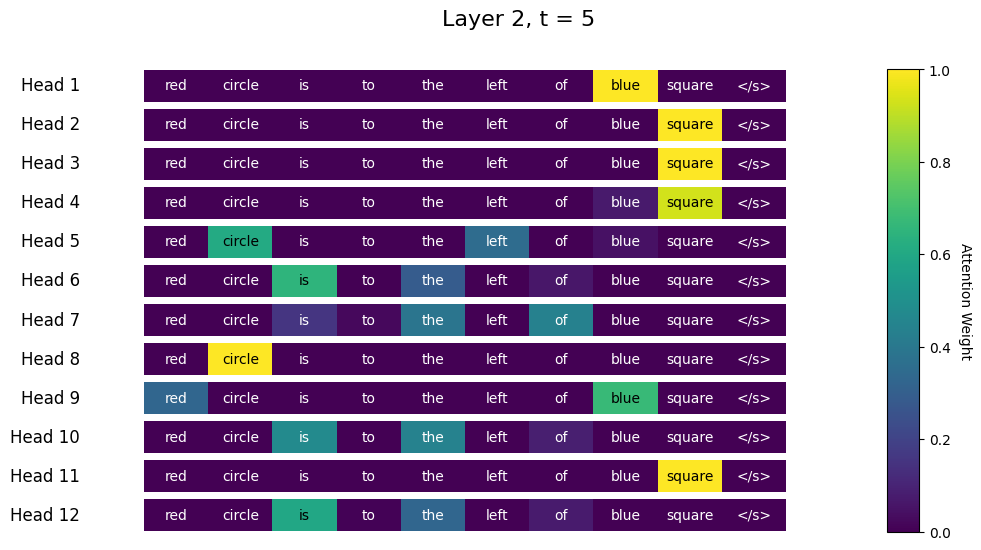

/tmp/ipykernel_2359256/2652938256.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


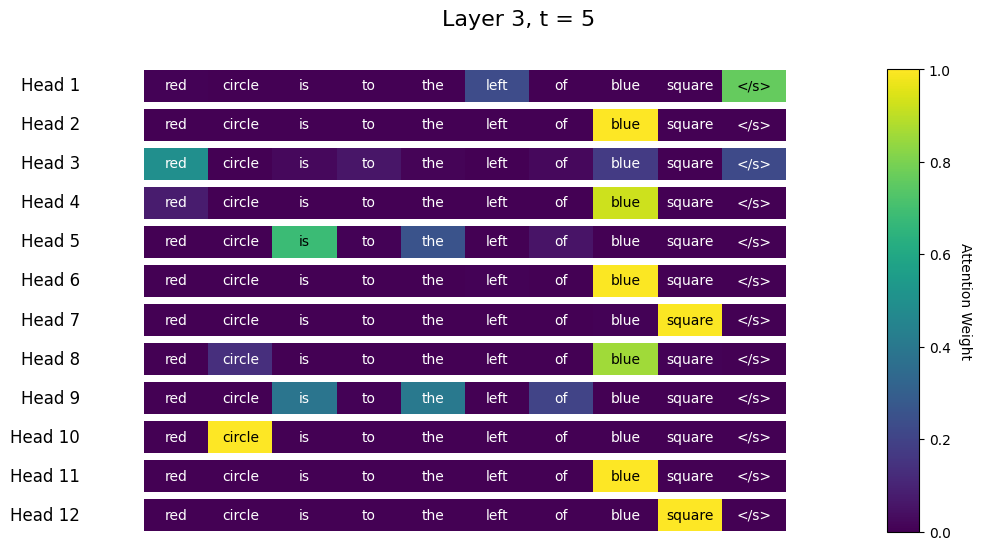

/tmp/ipykernel_2359256/2652938256.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


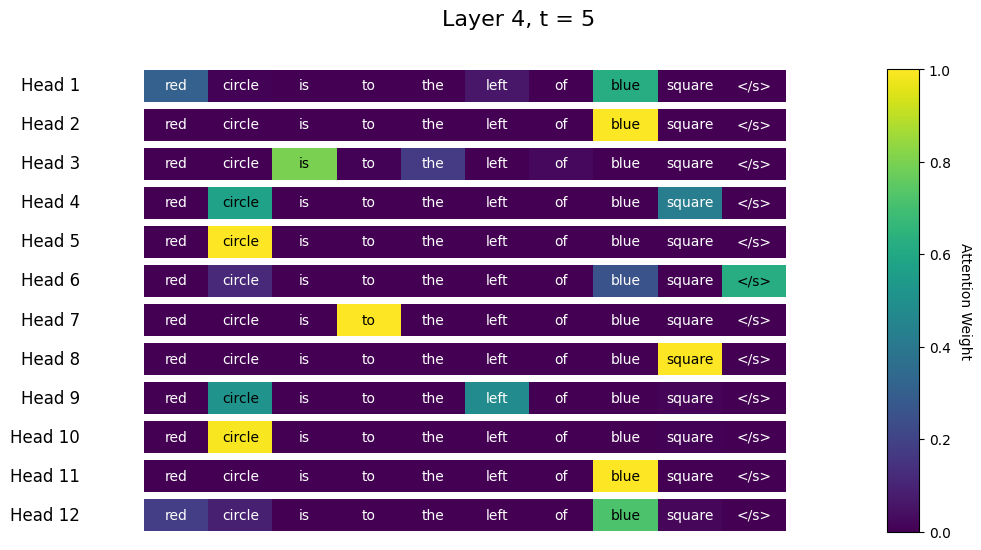

/tmp/ipykernel_2359256/2652938256.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


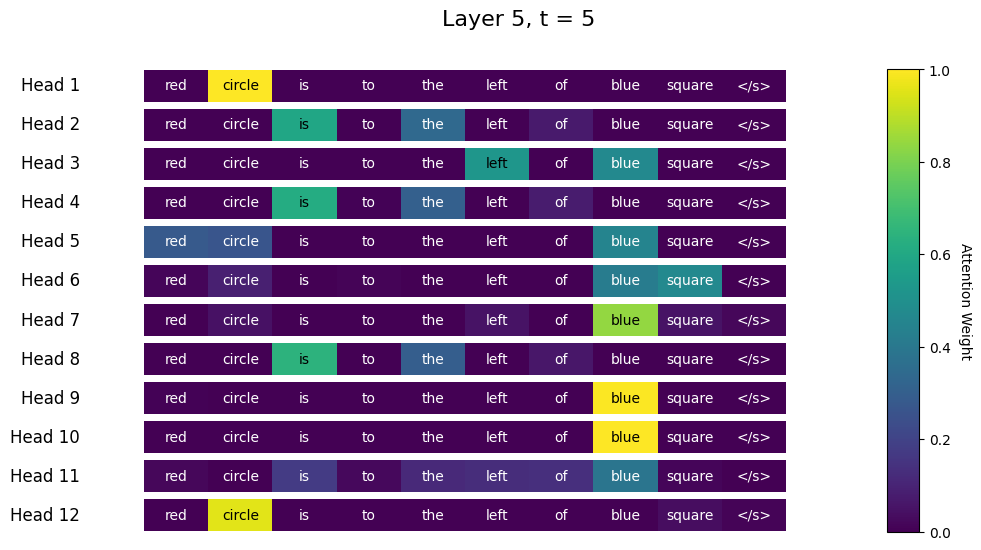

/tmp/ipykernel_2359256/2652938256.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


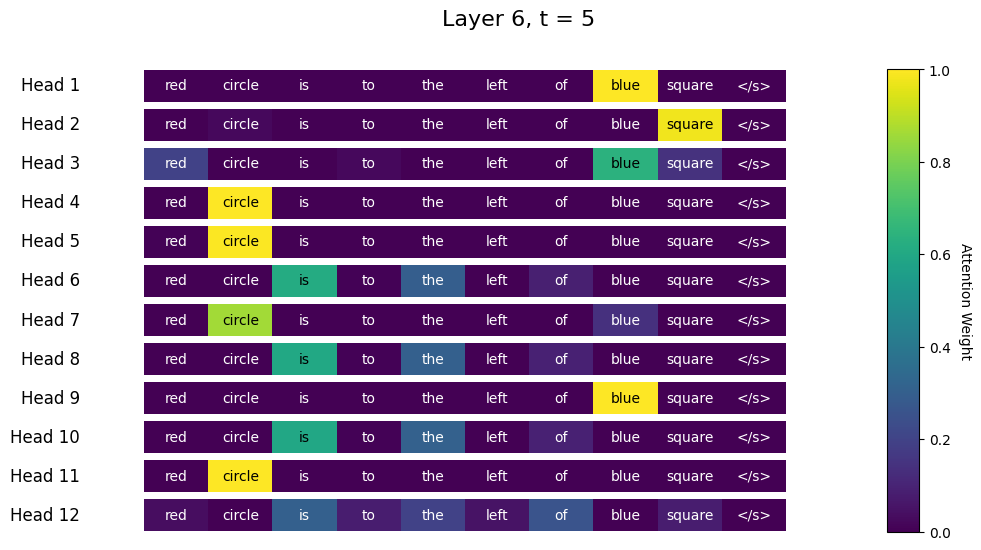

/tmp/ipykernel_2359256/2652938256.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


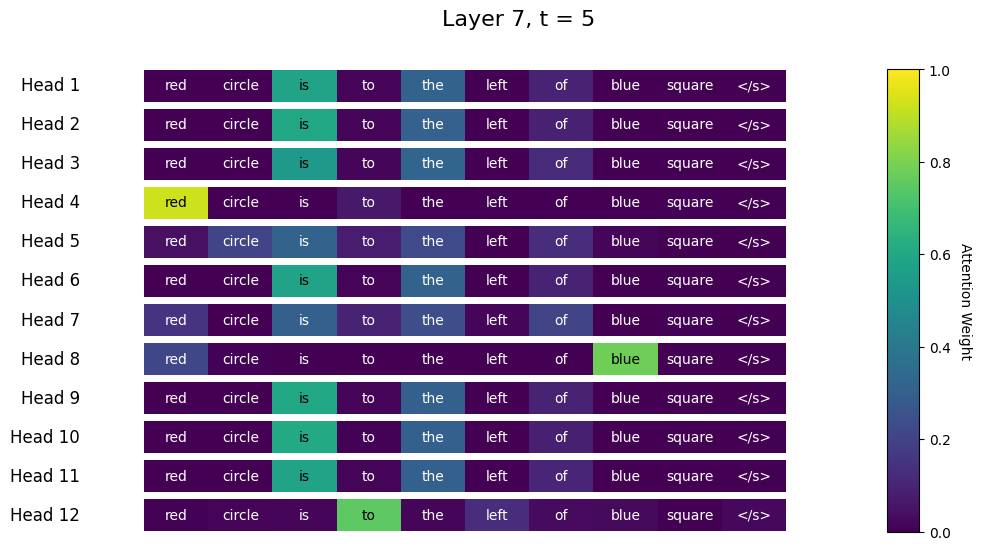

/tmp/ipykernel_2359256/2652938256.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


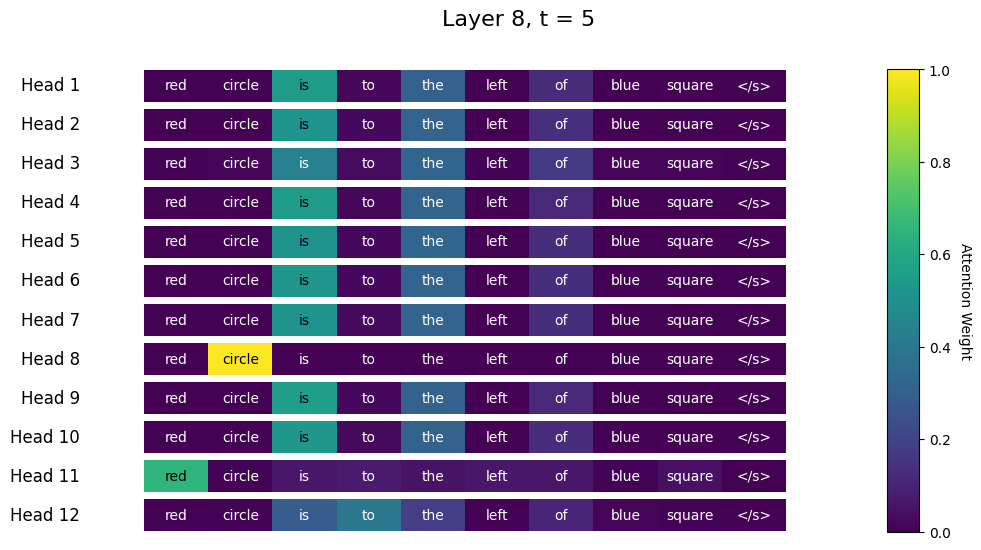

/tmp/ipykernel_2359256/2652938256.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


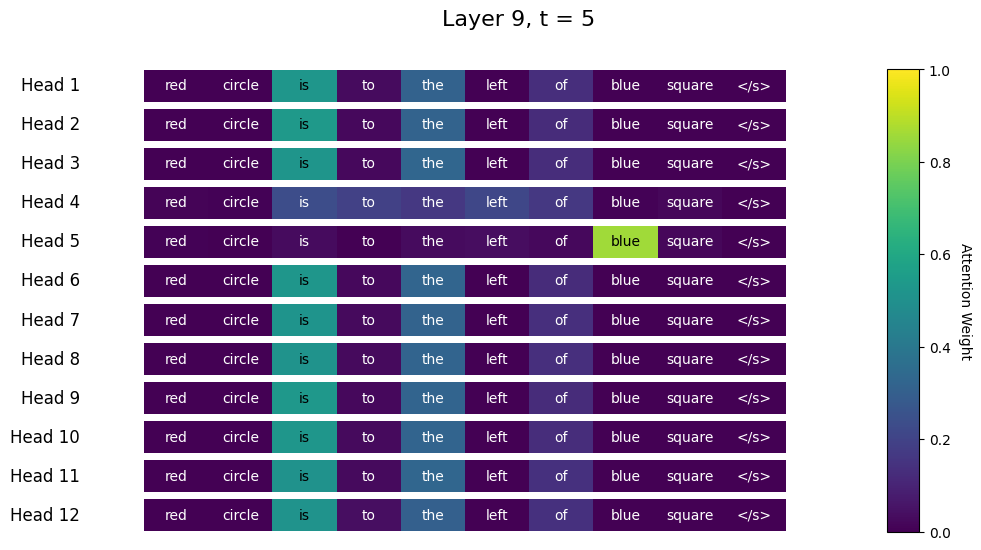

/tmp/ipykernel_2359256/2652938256.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


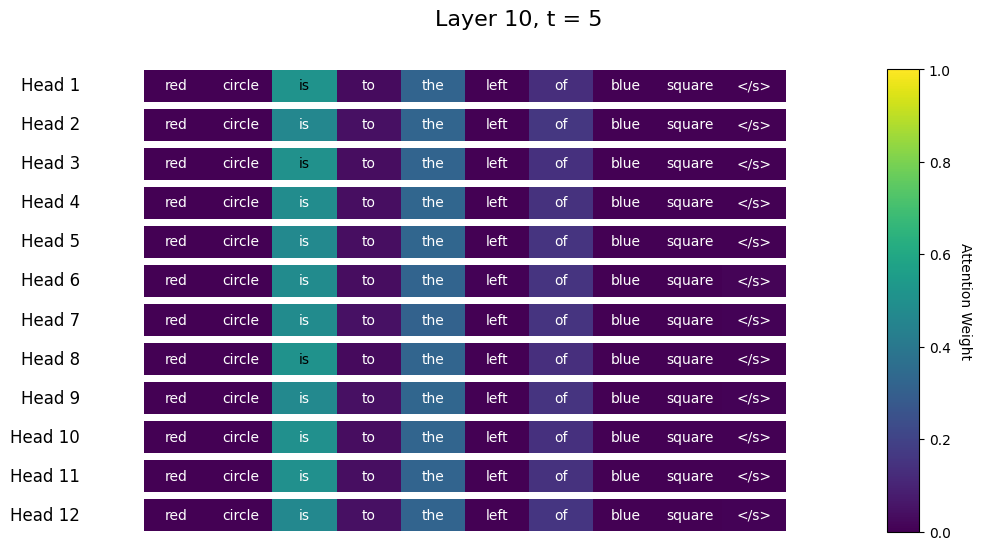

/tmp/ipykernel_2359256/2652938256.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


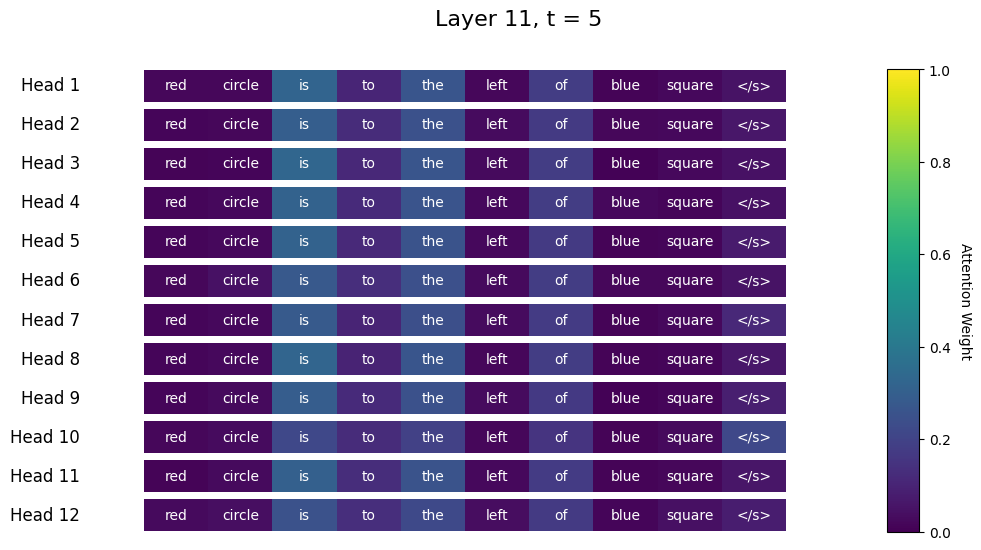

In [26]:
layer = 8
for layer in range(12):
    t = 5
    (attention_map, word_tokens, fig) = pipeline.feature_vector_cross_attn_map(layer, latent, prompt, title = f"Layer {layer}, t = {t}")

In [27]:
# layer = 1
# feature = np.random.randn(768)
# prompt = validation_prompts[7:8][0]

# attn_map = pipeline.feature_vector_cross_attn_map(layer, feature, prompt)
# attention_map = attn_map.detach().cpu().numpy()

# word_tokens = tokenizer.convert_ids_to_tokens(pipeline.tokenizer.encode(prompt))
# word_tokens = [token.replace("▁", "") for token in word_tokens]
# word_tokens

# attention_map = attention_map[:, 0:len(word_tokens)]

In [28]:
# word_tokens

In [29]:
# attention_map.shape

In [30]:
# # visualize the attention map. put color background on text. The plot should have 12 subplots, each represent a head.
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np # Required for np.linspace and np.empty

# # Set up the figure and axes, including space for a global colorbar
# # Create a GridSpec to manage subplot layout and allocate space for the colorbar
# # We'll have 12 rows for the main plots and an additional narrow column for the colorbar.
# num_heads = 12
# # Adjusted figure size for a single column layout
# # Width is reduced, height is increased to accommodate all 12 plots vertically.
# fig_width = 10 # Adjusted width for a single column
# fig_height_per_plot = 0.5 # Approximate height for each plot
# fig = plt.figure(figsize=(fig_width, fig_height_per_plot * num_heads))

# # Create a GridSpec with 12 rows for plots and 2 columns (1 for plots, 1 for colorbar)
# gs = fig.add_gridspec(num_heads, 2, width_ratios=[1, 0.05], wspace=0.3)

# # Create a list to store subplot axes, one for each head
# axes = []
# for i in range(num_heads):
#     ax = fig.add_subplot(gs[i, 0]) # Each plot occupies a full row in the first column
#     axes.append(ax)

# # Create a dedicated axis for the global colorbar, spanning all rows in the last column
# cbar_ax = fig.add_subplot(gs[:, 1])

# fig.suptitle('Attention Map Visualization', fontsize=16)

# # Adjust the attention_map to ensure it matches the expected shape
# # This line ensures that the attention_map has the correct number of columns
# # corresponding to the word tokens.
# attention_map = attention_map[:, :len(word_tokens)]

# mappable_for_cbar = None # Initialize a variable to store a mappable object for the global colorbar

# # Iterate over each head
# for i in range(num_heads):
#     ax = axes[i] # Get the current subplot axis from the list
#     head_attention = attention_map[i].reshape(1, -1) # Reshape to (1, N) for heatmap

#     # Plot heatmap with specified vmin/vmax (0-1 range) and no individual colorbar
#     heatmap_plot = sns.heatmap(head_attention, ax=ax, cmap='viridis', cbar=False,
#                                xticklabels=False, yticklabels=False, vmin=0, vmax=1)

#     # Set aspect ratio to make cells wider than tall, giving a "background for text" feel.
#     # A value less than 1 makes the cells wider relative to their height.
#     ax.set_aspect(0.5) # Adjust this value (e.g., 0.3 to 0.7) for desired text background shape

#     # Store the mappable object (QuadMesh) from the first heatmap for the global colorbar
#     if mappable_for_cbar is None:
#         mappable_for_cbar = heatmap_plot.collections[0]

#     # Add text (word tokens) on top of the colors
#     for j, token in enumerate(word_tokens):
#         value = head_attention[0, j]
#         # Choose text color based on background intensity for readability
#         # A simple heuristic: if value is low (dark background), use white text; otherwise, black.
#         text_color = 'white' if value < 0.5 else 'black'
#         ax.text(j + 0.5, 0.5, token, ha='center', va='center', color=text_color, fontsize=10)

#     # Place the subplot title on the left center, outside the subplot
#     ax.text(-0.1, 0.5, f'Head {i+1}', ha='right', va='center', transform=ax.transAxes, fontsize=12)
    
#     # Remove ticks and labels as text is placed directly on the heatmap
#     ax.set_xticks([])
#     ax.set_yticks([])

# # Create a single colorbar for the entire figure using the stored mappable object
# if mappable_for_cbar:
#     cbar = fig.colorbar(mappable_for_cbar, cax=cbar_ax, orientation='vertical')
#     cbar.set_label('Attention Weight', rotation=270, labelpad=15)
#     cbar.set_ticks(np.linspace(0, 1, 6)) # Set ticks from 0 to 1 (e.g., [0.0, 0.2, ..., 1.0])
#     cbar.ax.tick_params(labelsize=10) # Adjust colorbar tick label size

# # Adjust rect to make space for suptitle, colorbar, and the new left-aligned head labels
# # plt.tight_layout(rect=[0.05, 0.03, 1, 0.95]) # Increased left margin to accommodate head labels
# plt.tight_layout()
# plt.show()


In [31]:
# # create a random tensor with shape [1,1,768]
# norm_hidden_states = torch.randn(1,1,768).to("cuda")
# prompt = validation_prompts[7:8][0]

# prompt_embeds, prompt_attention_mask = pipeline.get_encoder_hidden_states(prompt)
# encoder_hidden_states = pipeline.transformer.caption_projection(prompt_embeds)
# encoder_attention_mask = prompt_attention_mask

# attn_output = cross_attn_layer(
#                 norm_hidden_states,
#                 encoder_hidden_states=encoder_hidden_states,
#                 attention_mask=encoder_attention_mask
#             )

# cross_attn_layer.processor.attn_map.shape

In [32]:
# def feature_vector_cross_attn_map(pipeline, layer, feature, prompt):
#     '''
#     feature: shape [768]
#     prompt: str
#     output: shape [heads, prompt_tokens]
#     '''
#     cross_attn_layer = pipeline.transformer.transformer_blocks[layer].attn2
    
#     norm_hidden_states = torch.from_numpy(feature).to("cuda")
#     norm_hidden_states = norm_hidden_states.unsqueeze(0).unsqueeze(0)

#     prompt_embeds, prompt_attention_mask = pipeline.get_encoder_hidden_states(prompt)
#     encoder_hidden_states = pipeline.transformer.caption_projection(prompt_embeds)
#     encoder_attention_mask = prompt_attention_mask

#     attn_output = cross_attn_layer(
#                     norm_hidden_states,
#                     encoder_hidden_states=encoder_hidden_states,
#                     attention_mask=encoder_attention_mask
#                 )

#     return cross_attn_layer.processor.attn_map

In [33]:
# feature_vector_cross_attn_map